<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Anomaly Detection in Network Data using GPU-Accelerated XGBoost

- Ananth Sankar, Solutions Architect at NVIDIA.
- Eric Harper, Solutions Architect, Global Telecoms at NVIDIA.

As network traffic continues to grow exponentially, the number of network attacks and the different kinds of attacks is also growing. The ability to quickly and frequently train machine learning models to detect network intrusions is more important now than ever.

In this series of labs, we will learn how to use machine learning and deep learning models for detecting network intrusions in the full KDD99 dataset. The data processing and model training techniques that will be learned in these labs can be applied to many datasets for anomaly detection problems.

The KDD99 dataset consists of normal data points and points that have been labeled as Denial of Service (DoS), Remote to User (R2L), User to Root (U2R), and Probing (Probe) by logging network packet information. More information about the dataset can be found at https://kdd.ics.uci.edu/databases/kddcup99/task.html. 


We'll start off by exploring the dataset and then we will use the NVIDIA RAPIDS library to train GPU-accelerated XGBoost models for network intrusion detection. The RAPIDS suite of software libraries, built on CUDA-X AI, gives you the freedom to execute end-to-end data science and analytics pipelines entirely on GPUs. It relies on NVIDIA® CUDA® primitives for low-level compute optimization, but exposes that GPU parallelism and high-bandwidth memory speed through user-friendly Python interfaces.

Notice that we will also be using the Pandas and Scikit-learn packages in this lab. 

In [1]:
# Import libraries that will be needed for the lab

import xgboost as xgb
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle

# Set the seed for numpy
np.random.seed(123)

# Display all columns of Pandas' dataframes by default
pd.set_option('display.max_columns', None)

data_path = './data/kddcup.data.corrected'

## Section 1: Data

### 1.1 Load the Dataset

Let's begin by first importing the KDD99 Dataset using Pandas and then doing some basic data exploration.

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_csv(data_path, header=None, names=col_names, index_col=False)

# Display the first few rows of the dataset
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


Each row of the KDD Cup 99 dataset is a network connection, with a total of 41 independent variables and 1 dependent variable. The independent variables can be broadly divided into three groups:

1. Basic input features of network connections such as duration, protocol type, and number of bytes from source IP addresses 
2. Content input features of network connections
3. The statistical input features computed over a time window

Scroll to the right of the above cell to see all of the features.  The last column on the right is the "Label" column. This indicates whether the row is normal or some type of anomalous network traffic.

Let's see what types of anomalies are in our dataset.

In [3]:
pd.DataFrame(df['label'].value_counts())

,label
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020
teardrop.,979


In [4]:
# here we train a label encoder so that we can map our classes to integers later for model training
le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

['back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.' 'imap.'
 'ipsweep.' 'land.' 'loadmodule.' 'multihop.' 'neptune.' 'nmap.' 'normal.'
 'perl.' 'phf.' 'pod.' 'portsweep.' 'rootkit.' 'satan.' 'smurf.' 'spy.'
 'teardrop.' 'warezclient.' 'warezmaster.']


### 1.2 Dataset Modification

Notice that the dataset has more anomalies than normal data. Reflect for a moment about the implications of having more anomalies might be. Reflect either here in the notebook, on a piece of paper, or with a peer sitting next to you.

We'll come back to test your hypothesis shortly. 

<a id='return'></a>

### 1.3 Data Preprocessing

In order to train an XGBoost model, we have to encode the strings in categorical variables to numeric terms. 

We will use one-hot encoding to translate each of the 7 categorical features:  `protocol type`, `service`, `flag`, `land`, `logged_in`, `is_host_login`, `is_guest_login` using the Pandas function `get_dummies()`. One-hot encoding will transform the categorical variable into a numerical variable for each category. If a category takes ten values, then that categorical variable will be transformed into 10 numerical variables.

### 1.4 One-hot Encode the Categorical Data

In [5]:
# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

# check that the categorical variables were created correctly
cat_data.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


<br>
Scroll to the right to notice the new categories that were created. For example, the categorical variable "protocol_type" is split into three categories, protocol_type_icmp, protocol_type_tcp and protocol_type_udp. Now that the one hot encoding of the categorical data is done, we need to merge the numerical data from the original data. 
<br>
<br>

In [6]:
numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

# check that the numeric data has been captured accurately
numeric_data.head()

,srv_serror_rate,dst_host_serror_rate,num_shells,num_access_files,dst_host_srv_rerror_rate,root_shell,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_serror_rate,wrong_fragment,num_failed_logins,same_srv_rate,urgent,serror_rate,rerror_rate,dst_bytes,diff_srv_rate,dst_host_rerror_rate,hot,duration,num_root,srv_count,srv_rerror_rate,num_compromised,num_file_creations,dst_host_srv_count,src_bytes,count,dst_host_count,su_attempted,srv_diff_host_rate,dst_host_srv_diff_host_rate,num_outbound_cmds,dst_host_diff_srv_rate
0,0.0,0.0,0,0,0.0,0,0.0,0.00,0.0,0,0,1.0,0,0.0,0.0,45076,0.0,0.0,0,0,0,1,0.0,0,0,0,215,1,0,0,0.0,0.0,0,0.0
1,0.0,0.0,0,0,0.0,0,1.0,1.00,0.0,0,0,1.0,0,0.0,0.0,4528,0.0,0.0,0,0,0,2,0.0,0,0,1,162,2,1,0,0.0,0.0,0,0.0
2,0.0,0.0,0,0,0.0,0,1.0,0.50,0.0,0,0,1.0,0,0.0,0.0,1228,0.0,0.0,0,0,0,1,0.0,0,0,2,236,1,2,0,0.0,0.0,0,0.0
3,0.0,0.0,0,0,0.0,0,1.0,0.33,0.0,0,0,1.0,0,0.0,0.0,2032,0.0,0.0,0,0,0,2,0.0,0,0,3,233,2,3,0,0.0,0.0,0,0.0
4,0.0,0.0,0,0,0.0,0,1.0,0.25,0.0,0,0,1.0,0,0.0,0.0,486,0.0,0.0,0,0,0,3,0.0,0,0,4,239,3,4,0,0.0,0.0,0,0.0


In [7]:
# concat numeric and the encoded categorical variables
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# here we do a quick sanity check that the data has been concatenated correctly by checking the dimension of the vectors
print(cat_data.shape)
print(numeric_data.shape)
print(numeric_cat_data.shape)

(4898431, 88)
(4898431, 34)
(4898431, 122)


<br>
Now let's split the data into training set and test set in the ratio of 75:25. We will be using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">LabelEncoder</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform">fit_transform</a> and <a href="https://scikit-https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">train_test_split</a> from scikit-learn.
<br>

In [8]:
# capture the labels
labels = df['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

<br>
We can inspect the dimension of the testing set and the training set to confirm that the data has been split correctly. We will also save the dataset to be used in the later portion of this lab and in lab-2 by "pickling" the data. Pickling allows us to save a python object as a binary file.
<br>

In [9]:
# check that the dimensions of our train and test sets are okay
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3673823, 122)
(3673823,)
(1224608, 122)
(1224608,)


In [10]:
# save the datasets for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
path = 'preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

We will approach this anomaly detection problem in two ways:

1. Implementing binary classification where we will label the Normal frames as '0' and Anomalous frames as '1' and use a 'one vs all' approach to detect an anomalous frame
2. Implementing multi-class classification where we will be able to detect the *type* of anomaly as well using our original y_train and y_test labels

## Section 2: Training a Binary Classifier

In the following cell, you will convert to binary labels. Remember what you do here as you will implement the multi-class solution yourself later.

In [11]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())


Number of anomalies in y_train:  2944214
Number of anomalies in y_test:   981436


We see that the anomalies are optimally split between the training set and the testing set. Now that we have prepared the data, we are ready to train an XGBoost model to detect anomalies. 
<br>

### 2.1 Training GPU XGBoost Models with RAPIDS

#### XGBoost

XGBoost is widely known today as a "go to" model when working with structured data such as the KDD99 dataset. In fact, there are a disproportionately large number of XGBoost-based winning entries of Kaggle competitions.

What is XGBoost and why is it so popular?

Traditionally, in tree-based ensemble methods such as Random Forests, we train each tree independently. The predictions of multiple trees are summed to obtain the final score. The figure below classifies whether someone would like to play a certain computer game or not.

<img src="images/twocart.png" alt="Alt text that describes the graphic" title="Title text" width=700px>

<div align="center" style="color:gray;">
    <em>Image courtesy <a href="https://goo.gl/eTxVtA">goo.gl/eTxVtA<a/></em>
</div>
<hr>

In the case of XGBoost, an implementation of Gradient Boosted Decision Trees, we repeatedly build new models and combine them into an ensemble. Unlike Random Forests, we build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

<img src="https://drive.google.com/uc?id=1WDN-kDMOsIhY3vWy8UBOR0qgBRHqbf-2" alt="Alt text that describes the graphic" title="Title text" width=700px>

*The objective of the XGBoost model is as follows:*

<img src=images/xgboost-objective.PNG alt="Alt text that describes the graphic" title="Title text" />

The loss function controls the predictive power of the model, and the XGBoost regularization term ensures simplicity and manages overfitting.

Since Boosting focuses step by step on the difficult examples it gives it a nice strategy to deal with unbalanced datasets by strengthening the impact of the positive class.

### 2.2 Why Use GPU to Accelerate XGBoost?

Generally, GPU accelerated XGBoost models will train much faster. It's also extremely easy.  In order to use the GPU version of XGBoost, only one parameter in the code has to be set (see below): ```{'tree_method': 'gpu_hist'```} Also, the environment must have the GPU version of XGBoost: https://xgboost.readthedocs.io/en/latest/gpu/index.html. The easiest way to use GPU XGBoost is to use NVIDIA's RAPIDS container: https://hub.docker.com/r/rapidsai/rapidsai/. 

Machine learning models using XGBoost on large datasets can take several hours to train and achieve the best predictions. Oftentimes, models have to be trained for 1000s of iterations, and usually many different combinations of hyperparameters must be tested.

The more models that can be trained, the better the accuracy will be.

<img src=images/moremodels.PNG alt="Alt text that describes the graphic" title="Title text" />

Fortunately, the XGBoost algorithm is highly parallelizable by virtue of requiring scans across gradient values and using these partial sums to evaluate the quality of splits at every possible split in the training set. By utilizing fast parallel prefix operations to scan through all possible splits as well as parallel radix sorting to repartition data, the GPU accelerated version builds a decision tree for a given boosting iteration one level at a time, processing the entire dataset concurrently on the GPU.

### 2.3 Hyperparameter Tuning

Hyperparameters can have a huge impact on the performance of XGBoost models.
Some of the more important ones are listed below. See [here](https://xgboost.readthedocs.io/en/latest/parameter.html) for a description of all parameters and see [here](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) for a guide to tuning XGBoost models. Feel free to try out different combinations: 
<ul>
<li>
<b>objective:</b>
Depending on whether we treat our problem as a binary classification problem or as a multi-class classification problem this parameter would be either binary:logistic or multi:softmax respectively.
    </li>
<li>
<b>tree_method:</b>
gpu_exact to use the GPU optimized exact greedy algorithm and gpu_hist to use the histogram optimized approximate greedy algorithm. For GPU accelerated XGBoost it is best to use gpu_hist.
    </li>
<li>
<b>n_gpus:</b>
The number of GPUs to use for training.  Note, if using GPU DASK, n_gpus should be set to 1.
    </li>
    
<li>
<b>max_depth:</b>
Increasing this value will give the model more capacity to learn and it will also be more likely to overfit. If using a large max_depth value, make sure to increase the regularization.
</li>

<li>
<b>learning_rate:</b>
Used to control the weighting of new trees added to the model. If using a low value here, then the number of rounds of training should be high.
</li>

<li>
<b>num_class:</b>
    Indicates the number of classes in the label column. For a binary classification problem this should be 2 and the number of classes in the case of a multi-class problem.
</li>

In [12]:
params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'n_gpus':            1,
    'objective':         'binary:logistic',
    'verbose':           True
}

### 2.4 Binary Classification Model Training

Let us look at the feature and label columns of our training set before we start training our XGBoost model.

In [13]:
x_train.head()

,srv_serror_rate,dst_host_serror_rate,num_shells,num_access_files,dst_host_srv_rerror_rate,root_shell,dst_host_same_srv_rate,dst_host_same_src_port_rate,dst_host_srv_serror_rate,wrong_fragment,num_failed_logins,same_srv_rate,urgent,serror_rate,rerror_rate,dst_bytes,diff_srv_rate,dst_host_rerror_rate,hot,duration,num_root,srv_count,srv_rerror_rate,num_compromised,num_file_creations,dst_host_srv_count,src_bytes,count,dst_host_count,su_attempted,srv_diff_host_rate,dst_host_srv_diff_host_rate,num_outbound_cmds,dst_host_diff_srv_rate,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
3316061,0.0,0.0,0,0,0.0,0,1.0,1.0,0.0,0,0,1.0,0,0.0,0.0,0,0.0,0.0,0,0,0,511,0.0,0,0,255,1032,511,255,0,0.00,0.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
239340,0.0,0.0,0,0,0.0,0,1.0,0.0,0.0,0,0,1.0,0,0.0,0.0,462,0.0,0.0,0,0,0,28,0.0,0,0,255,199,27,255,0,0.07,0.0,0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4219707,0.0,0.0,0,0,0.0,0,1.0,1.0,0.0,0,0,1.0,0,0.0,0.0,0,0.0,0.0,0,0,0,511,0.0,0,0,255,520,511,255,0,0.00,0.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3212920,0.0,0.0,0,0,0.0,0,1.0,1.0,0.0,0,0,1.0,0,0.0,0.0,0,0.0,0.0,0,0,0,511,0.0,0,0,255,1032,511,255,0,0.00,0.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
190138,0.0,0.0,0,0,0.0,0,1.0,0.0,0.0,0,0,1.0,0,0.0,0.0,924,0.0,0.0,0,0,0,4,0.0,0,0,255,285,4,255,0,0.00,0.0,0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [14]:
y_train[0:100]

array([18, 11, 18, 18, 11, 18,  9, 18,  9, 11, 11, 18, 18, 11, 18,  9, 18,
       11, 18, 18, 18,  9, 18, 18, 11, 18, 18,  9, 18, 11, 18,  9, 18, 11,
        9, 11,  9, 18, 18, 18, 18, 18, 18, 18, 11, 18,  9, 18,  9, 18, 18,
       11, 11, 18, 18,  9, 18, 18, 18,  9, 18, 11, 18,  9, 18, 18,  9,  9,
       11, 18, 18,  9, 11, 18, 11, 11, 11, 11, 18, 18,  9, 18, 18, 11, 11,
       11, 11, 18, 11, 11, 18, 11,  9, 18,  9, 18, 18, 18,  9, 18])

In [15]:
%%time 

dtrain = xgb.DMatrix(x_train, label=binary_y_train)
dtest = xgb.DMatrix(x_test, label=binary_y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

CPU times: user 15.2 s, sys: 1.24 s, total: 16.5 s
Wall time: 3.42 s


In [16]:
num_rounds = params['num_rounds']

In [17]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[13:50:38] WARNING: ../src/learner.cc:576: 
Parameters: { "n_gpus", "num_rounds", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:50:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.59826	train-logloss:0.59825
[1]	test-logloss:0.52054	train-logloss:0.52053
[2]	test-logloss:0.45574	train-logloss:0.45572
[3]	test-logloss:0.40096	train-logloss:0.40094
[4]	test-logloss:0.35417	train-logloss:0.35414
[5]	test-logloss:0.31386	train-logloss:0.31383
[6]	test-logloss:0.27890	train-logloss:0.27887
[7]	test-logloss:0.24841	train-loglos

We can use the `nvidia-smi` shell command to see that data has been moved automatically to the GPU for training. Note the memory utilization under the column *Memory-Usage* after running the following cell.

In [18]:
!nvidia-smi

Sat Apr 12 13:50:40 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   31C    P0    90W / 300W |   2277MiB / 22731MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 2.5 Testing and Evaluation

If you scroll to the section where we declared our XGboost parameters, we see that we have set the objective to be `binary:logistic`.

In a binary logistic classifier we usually set the threshold at 0.5 meaning all probability scores >= 0.5 will be assigned 1 (Anomaly) and those with scores < 0.5 will be assigned 0 (Normal).

This will help us calculate the accuracy as we will see in the coming sections.

First let's look at our predictions.

In [19]:
threshold = .5
true_labels = binary_y_test.astype(int)
true_labels.sum()

981436

In [20]:
# make predictions on the test set using our trained model
preds = model.predict(dtest)
print(preds)

[0.17959377 0.82072806 0.17959377 ... 0.17959377 0.82072806 0.82072806]


In [21]:
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[0 1 0 ... 0 1 1]


In [22]:
pred_labels.sum()

981347

### 2.6 Area under the Curve (AUC)

The area under the ROC curve is a great metric for determining how well your classification model is performing, even in the case of imbalanced classes. A score of 1 means your model is performing perfectly, while a score of .5 means that your model is the same as randomly guessing. [See here for more information](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

In [23]:
# compute the auc
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9999722972966026


We should be getting near a perfect score here.

### 2.7 Accuracy
Accuracy is the ratio of correct classifications to the total number of samples.  Accuracy is often misleading in anomaly detection problems where the classes are highly imbalanced.

In [24]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9997329757767384


The accuracy should be almost perfect.

### 2.8 Confusion Matrix

The Confusion Matrix represents the quality of the output of a classifier on any dataset. The diagonal elements represent correct or true labels, whereas the off-diagonal (white box in Figures 5 and 6) elements represent the elements misclassified by the classification model. Therefore, the higher the values of the diagonal elements of the confusion matrix, the better and more accurate the classification model becomes.

Confusion Matrix :


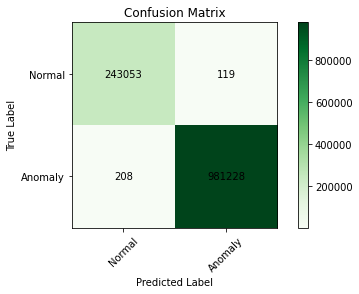

In [25]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

From the confusion matrix we can see that our model is performing really well.  It is able to classify almost all of the anomalies.  And this is without any tuning of XGBoost.  We can see why XGBoost is so popular.

### 2.9 AUC Part 2

The AUC curve is a plot of the True Positive Rate (TPR) against the False Positive Rate (FPR). The TPR is a measure of how often the prediction is correct, when there is a positive value, and the FPR is how often the prediction is incorrect when the value is in fact negative. 

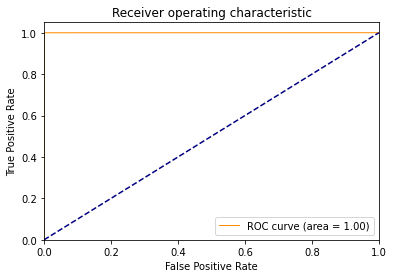

In [26]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The closer the curve is to the left-hand and the top-hand borders of the ROC plotting area, the better the model is performing over all thresholds. The area under the ROC curve (AUC) is a way of quantifying this performance. 1 is a perfect score.

### 2.10 Model Inspection

Why is our model performing so well? One tool we can use from XGBoost is the feature importance.  XGBoost will rank the features that it uses in determining a classification.  We can visualize the feature importance using the "plot_importance" method.  

Knowing which features are contributing the model can be really useful for solving business problems.  In the case of network security, those features can give us way to possibly preempt malicious activity.

Feature importance can also be a great way to debug your model. 

You might have to run this cell twice to see the feature importance.

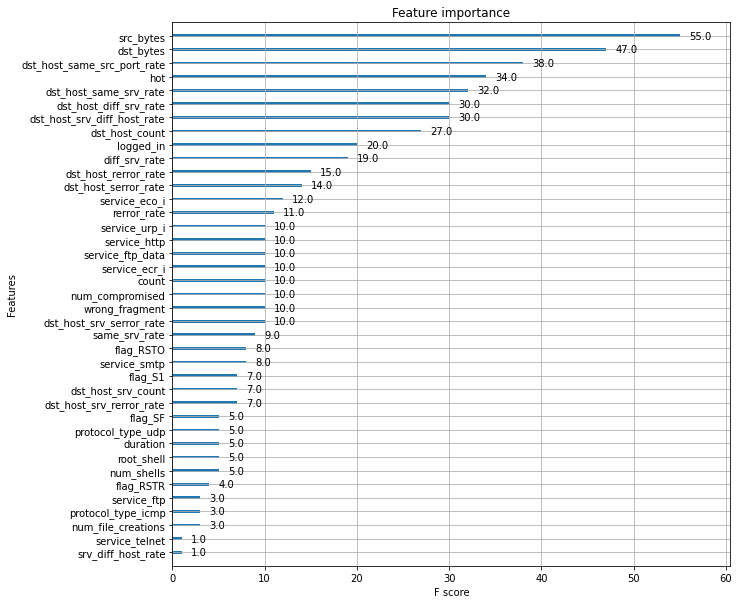

In [27]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

## Section 3: Impact of Skewed Data

As we prepared our data, we pointed out that there were more anomalies than normal data and considered the implications of this dataset skew that doesn't match the real world. Take a moment now see how adjusting our dataset impacts performance.

In [28]:
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal.'
    num_normal = np.sum(~is_anomaly)
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal.']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df

In [29]:
df_reduced_ano = reduce_anomalies(df)

Let's see what anomalies we have after the reduction.

In [30]:
pd.DataFrame(df['label'].value_counts())

,label
smurf.,2807886
neptune.,1072017
normal.,972781
satan.,15892
ipsweep.,12481
portsweep.,10413
nmap.,2316
back.,2203
warezclient.,1020
teardrop.,979


In [31]:
pd.DataFrame(df_reduced_ano['label'].value_counts())

,label
normal.,972781
smurf.,6903
neptune.,2705
portsweep.,41
ipsweep.,34
satan.,28
back.,7
nmap.,6
warezclient.,2
teardrop.,1


Return to [data preprocessing](#return) and rerun cells to this point, comparing and contrasting performance. Again, reflect below, on paper, or with a peer. Reflect on *why* the reduction of anomalies had the impact that it did.

What was the impact of reducing anomalies in the dataset and why do you think that is?

## Section 4:  Multi-Class Classification Model [Exercise]

We've seen that XGBoost can identify anomalies in the KDD99 dataset really easily.  Let's see if XGBoost can detect the different types of anomalies.  To do that we will train a multi-classification model.

We'll point out the difference, then have you implement the pieces that are the same using the binary classifier as a model.

For multi-classification models, the labels have to be converted to integers (we've already done this) and the 'objective
' and 'num_class' parameters must be changed accordingly.

### 4.1 Training the Model

In [32]:
num_labels = len(le.classes_)
params['objective'] = 'multi:softprob'
params['num_class'] = num_labels
print(params)

{'num_rounds': 10, 'max_depth': 8, 'max_leaves': 256, 'alpha': 0.9, 'eta': 0.1, 'gamma': 0.1, 'learning_rate': 0.1, 'subsample': 1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'tree_method': 'gpu_hist', 'n_gpus': 1, 'objective': 'multi:softprob', 'verbose': True, 'num_class': 23}


In the field below, set up `dtrain`, `dtest`, `evals`, and `model` as exemplified when we trained our binary classifier. 

Note: Multiclass labels are in y_train and y_test. Hint: Control F will help you find `dtrain`, `dtest`, `evals` and `model`.

You can see how adding multiple classes doesn't increase the complexity in training this type of model. 

In [39]:
print(y_test)

[11 18 11 ... 11 18 18]


In [40]:
%%time 

# dtrain = xgb.DMatrix(x_train, label=binary_y_train)
# dtest = xgb.DMatrix(x_test, label=binary_y_test)
# evals = [(dtest, 'test',), (dtrain, 'train')]

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

CPU times: user 14.2 s, sys: 1.24 s, total: 15.4 s
Wall time: 2.74 s


In [46]:
num_rounds = params['num_rounds']*3

In [47]:
multicls_model = xgb.train(params, dtrain, num_rounds, evals)

[14:01:27] WARNING: ../src/learner.cc:576: 
Parameters: { "n_gpus", "num_rounds", "scale_pos_weight", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:01:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-mlogloss:2.03136	train-mlogloss:2.03135
[1]	test-mlogloss:1.66738	train-mlogloss:1.66736
[2]	test-mlogloss:1.41898	train-mlogloss:1.41896
[3]	test-mlogloss:1.22980	train-mlogloss:1.22977
[4]	test-mlogloss:1.07778	train-mlogloss:1.07774
[5]	test-mlogloss:0.95161	train-mlogloss:0.95157
[6]	test-mlogloss:0.84469	train-mlogloss:0.84464
[7

### 4.2 Testing and Evaluation

Let us again evaluate our model on the test set and see how it performs. Note that accuracy now is a metric of how well we do on each of the 23 classes.

In [49]:
preds = multicls_model.predict(dtest)

In [50]:
pred_labels = np.argmax(preds, axis=1)

In [51]:
pred_labels

array([11, 18, 11, ..., 11, 18, 18])

In [52]:
true_labels = y_test

In [53]:
true_labels

array([11, 18, 11, ..., 11, 18, 18])

### 4.3 Accuracy

In [54]:
print ('Accuracy Score :', accuracy_score(true_labels, pred_labels))

Accuracy Score : 0.9999020094593535


We should be able to get near perfect accuracy. Let's look at the confusion matrix to make sure that we are detecting the anomalies.

### 4.4 Confusion Matrix

Confusion Matrix :


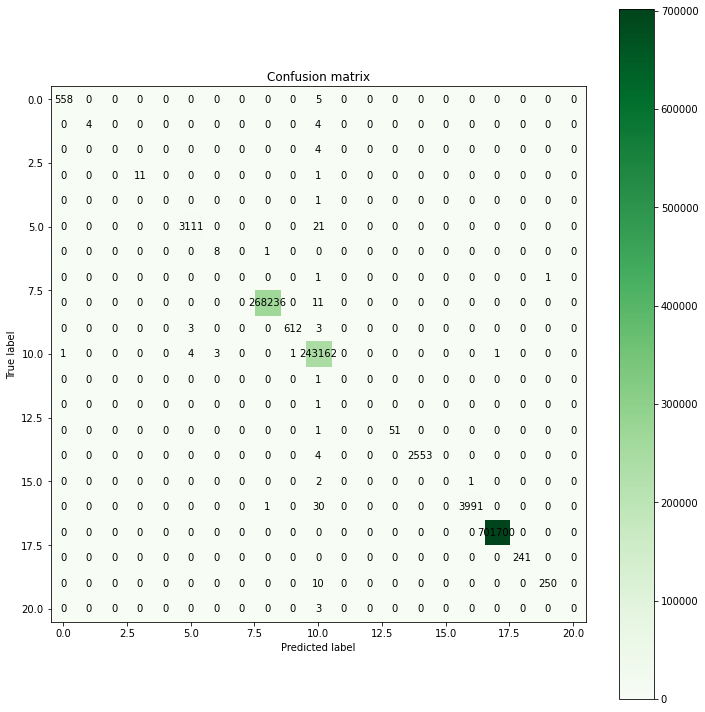

In [55]:
cm = confusion_matrix(true_labels, pred_labels)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    #tick_marks = np.arange(len(target_names))
    #plt.xticks(tick_marks, target_names, rotation=45)
    #plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Even the multi-class problem can be solved near perfectly with XGBoost.  

# Conclusion 

- As we saw in the binary and multi-class classification problems, XGBoost can be very effective at detecting anomalies when you have labeled data. In labs 2 and 3, we will consider the same KDD99 dataset but we will train deep learning models to detect anomalies without using the labels.  This will mimic a more likely situation is the real world.

- GPU-Accelerating XGboost through RAPIDS is easy and fast.  The only change we had to make to use the GPU was to set the 'tree_method' parameter to 'gpu_hist'.

# References

<ol>
<li>
Dhaliwal, S., Nahid, A., & Abbas, R. (2018). Effective Intrusion Detection System Using XGBoost. Information, 9(7), 149. doi:10.3390/info9070149
</li>
<li>
Brownlee, J. A Gentle Introduction to XGBoost for Applied Machine Learning. Machine Learning
Mastery. Available online: http://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
(accessed on 2 March 2018).
    </li>
    <li>A Study on NSL-KDD Dataset for Intrusion Detection System Based on Classification Algorithms. Available
online: https://pdfs.semanticscholar.org/1b34/80021c4ab0f632efa99e01a9b073903c5554.pdf (accessed on
        26 March 2018)</li>
    <li>
        XGBoost Parameters—Xgboost 0.7 Documentation. Available online: http://xgboost.readthedocs.io/en/
latest/parameter.html (accessed on 12 March 2018)
    </li>
    <li>
        RAPIDS Documentation and Cheat Sheet.Available online: https://rapids.ai/documentation.html
    </li>
    
   

<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>